##Домашнее задание № 2. Элементарные методы анализа временных рядов.

##Загрузим необходимые данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-18 15:49:58--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K  1.00MB/s    in 0.7s    

2025-02-18 15:49:59 (1.00 MB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [3]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [4]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [5]:
series = monthly_boston_armed_robberies_j['Count']

In [6]:
# вывод графика
def chart(series, title='Временной ряд'):
    plt.figure(figsize=(14, 7))
    plt.plot(series, label=title)
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

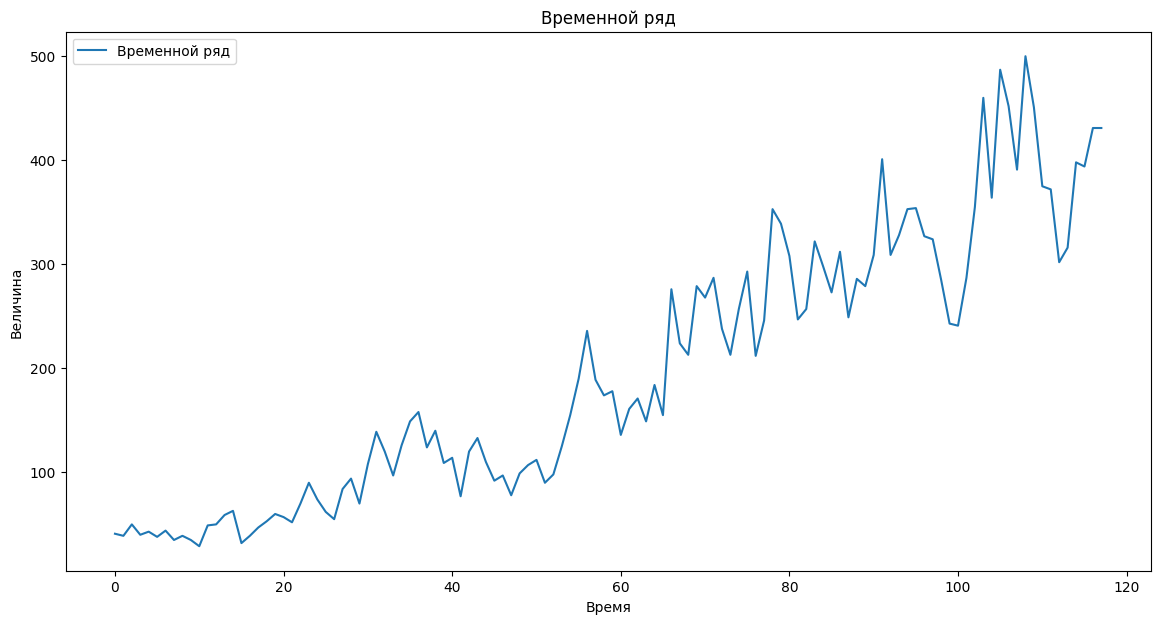

In [7]:
# еще раз на него посмотрим
chart(series)

Построим на его основе стационарный ряд

In [8]:
# зададим размер окна
window = 12

# вычислим скользящее среднее
rolling_mean = series.rolling(window=window).mean()

# детерминируем тренд
detrended = series - rolling_mean

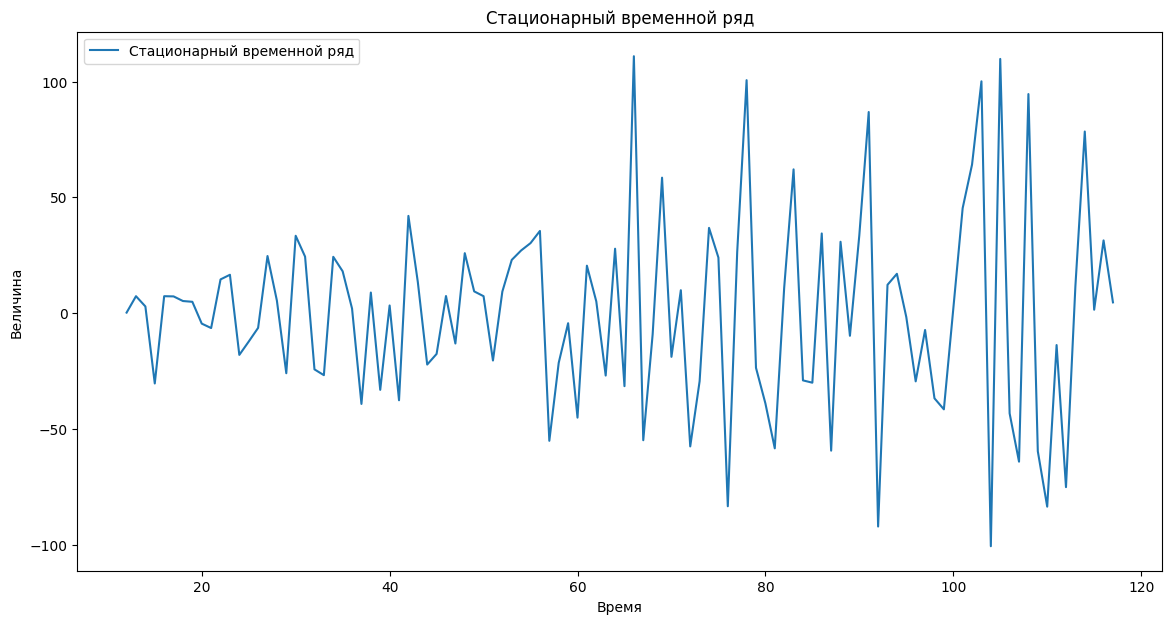

In [9]:
# применим дифференцирование к детерминированному ряду
differenced = detrended.dropna().diff().dropna()

# посмотрим
chart(differenced, 'Стационарный временной ряд')

In [10]:
# проверим на стационарность
from statsmodels.tsa.stattools import adfuller

res = adfuller(differenced.dropna())
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

Augmneted Dickey_fuller Statistic: -7.780023
p-value: 0.000000


##1. Скользящее среднее (MA)

In [11]:
# зададим размер окна
window = 12
# получим результат
ma = series.rolling(window).mean()

In [12]:
# вывод графиков
def chart_2(series_1, series_2, title):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

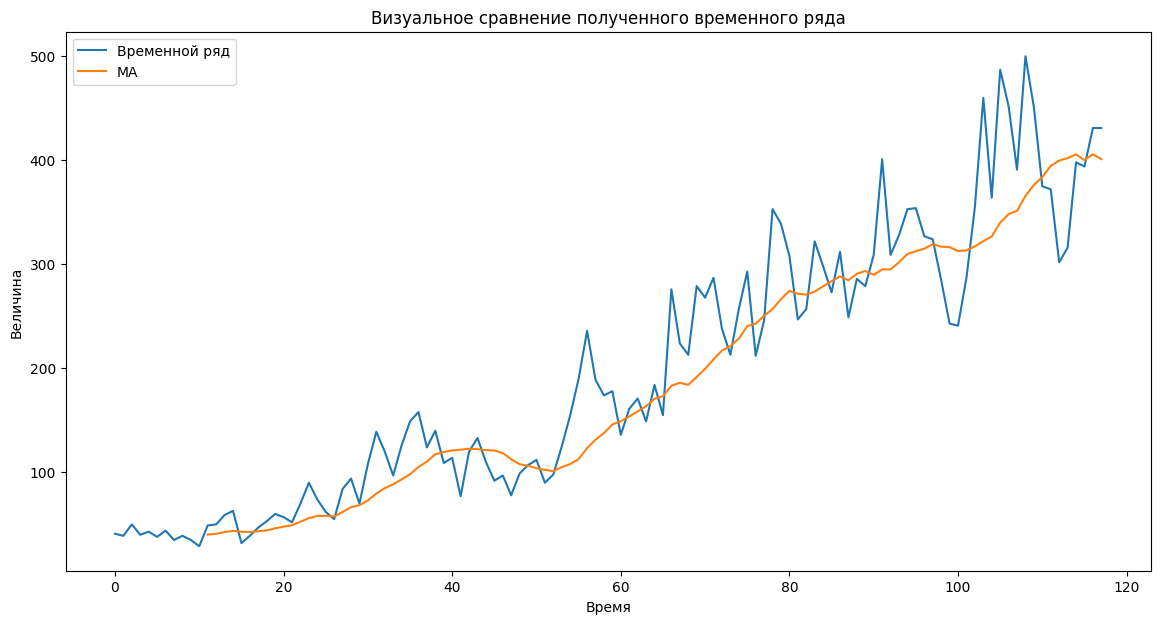

In [13]:
chart_2(series, ma, "MA")

In [36]:
# попрообую рассчитать RMSE
from sklearn.metrics import mean_squared_error
def rsme(series_t, series_p, window=12):

    y_true = series_t.dropna().to_numpy()[window-1:]
    y_pred = series_p.dropna().to_numpy()

    mse = mean_squared_error(y_true, y_pred)

    rmse = np.sqrt(mse)
    print(f'Root Mean Square Error (RMSE): {rmse}')

    return rmse

In [37]:
# RMSE
rsme(series, ma, window)

Root Mean Square Error (RMSE): 46.70893654724832


46.70893654724832

##Holt Winters

Рассчитаем Стандартизованную оценку (Z-Score) для каждого наблюдения, то есть меру удаленности от Среднего значения (Mean)

In [18]:
series['Standardized_assessment'] = (series['Count'] -
                                     series['Count'].mean()) / series['Count'].std(ddof=0)
series.head()

KeyError: 'Count'

In [ ]:
# разложим временной ряд на компоненты: тренд, сезонность и остатки
period = 12
decompose_result = seasonal_decompose(series['Count'],
                                      model='multiplicative',
                                      period=period)
decompose_result.plot()
plt.show()

Мне кажется, что прямо очень красиво такой сложный ряд разложился!

In [ ]:
# разделим временной ряд на Train и Test
s_train = series['Count'][:int(0.8*len(series['Count']))]
s_test = series['Count'][int(0.8*len(series['Count'])):]

In [ ]:
# создадим экземпляр класса Holt Winters
seasonal_periods = 12
model_triple = ExponentialSmoothing(s_train,
                                    seasonal_periods=seasonal_periods,
                                    trend='mul',
                                    seasonal='mul')
# обучим модель
model_triple_fit = model_triple.fit()

# получим предсказания на тестовом наборе
start = len(s_train)
end = len(series['Count'])-1
predictions = model_triple_fit.predict(start=start, end=end)

# получим предсказания на последующие периоды
next_periods = 24
predictions_next = model_triple_fit.predict(start=end, end=end+next_periods)

In [ ]:
# нарисуем
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
plt.plot(model_triple_fit.fittedvalues, label='Значения на train')
plt.plot(predictions, label='Прогноз на test')
plt.plot(predictions_next, label='Последующий прогноз')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.title('Тройное экспоненциальное сглаживание')
plt.legend()
plt.show()

In [ ]:
# оценим модель по MAE
mae = np.mean(np.abs(predictions-s_test))
print('Mean Absolute Error:', mae)

##Поиск по сетке. Экспоненциальное сглаживание Холта Винтера

Попробуем оптимизировать параметры

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# одношаговый прогноз экспоненциального сглаживания Холта Винтера
def exp_smoothing_forecast(train, test, config):
    # будем считаль, что период мы уже угадали верно
    seasonal_periods = 12
    t, d, s, r = config
	  # определим модель
    model = ExponentialSmoothing(train,
                                trend=t,
                                damped=d,
                                seasonal=s,
                                seasonal_periods=seasonal_periods)
	  # обучим модель
    model_fit = model.fit(optimized=True,
                          remove_bias=r
                         )
    # получим предсказания на тестовом наборе
    start = len(train)
    end = len(series['Count'])-1
    predictions = model_fit.predict(start=start, end=end)

    # оценим модель по MAE
    mae = np.mean(np.abs(predictions-test))

    return config, mae

In [ ]:
# создадим набор конфигураций экспоненциального сглаживания
def exp_smoothing_configs():
    models = list()
	  # определим выборочный список настроек
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    r_params = [True, False]
	  # создадим экземпляры конфигурации
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for r in r_params:
                    cfg = [t, d, s, r]
                    models.append(cfg)
    return models

In [ ]:
# поиск по сетке
def grid_search(cfg_list, train, test):
    scores = None
    result_cfg = []
    result_mae = []
    for cfg in cfg_list:
        try:
            config, mae = exp_smoothing_forecast(train, test, cfg)
            result_cfg.append(config)
            result_mae.append(mae)
        except:
            pass

    return result_cfg, result_mae

In [ ]:
# разделим временной ряд на Train и Test
train = series['Count'][:int(0.8*len(series['Count']))]
test = series['Count'][int(0.8*len(series['Count'])):]

In [ ]:
# конфигурации моделей
cfg_list = exp_smoothing_configs()
cfg_list[:5]

In [ ]:
# выпоним поиск по сетке
result_cfg, result_mae = grid_search(cfg_list, train, test)
print('Конец!')

In [ ]:
result_mae[:5]

In [ ]:
# найдем нименьшее значение и его индекс
min(result_mae), result_mae.index(min(result_mae))

In [ ]:
# найдем оптимальную конфигурацию
result_cfg[result_mae.index(min(result_mae))]

In [ ]:
# построим нашу оптимальную модель
seasonal_periods = 12
model = ExponentialSmoothing(train,
                             trend='add',
                             damped=False,
                             seasonal='add',
                             seasonal_periods=seasonal_periods)
# обучим модель
model_best = model.fit(optimized=True,
                       remove_bias=False
                      )
# получим предсказания на тестовом наборе
start = len(train)
end = len(series['Count'])-1
predictions = model_best.predict(start=start, end=end)

# получим предсказания на последующие периоды
next_periods = 24
predictions_next = model_best.predict(start=end, end=end+next_periods)

In [ ]:
# нарисуем лучшую модель
plt.figure(figsize=(14, 7))
plt.plot(series['Count'], label='Исходный ряд')
plt.plot(model_best.fittedvalues, label='Значения на train')
plt.plot(predictions, label='Прогноз на test')
plt.plot(predictions_next, label='Последующий прогноз')
plt.xlabel('Время')
plt.ylabel('Величина')
plt.title('Наша лучшая модель!')
plt.legend()
plt.show()

In [ ]:
# оценим модель по MAE
mae = np.mean(np.abs(predictions-test))
print('Mean Absolute Error:', mae)

Не факт, что стало лучше. Зато было интересно)